# 将Gated2Depth项目分解逐步处理

### 测试  


In [2]:
#  Copyright 2018 Algolux Inc. All Rights Reserved.
#  修改自dataset_util.py
import os
import cv2
import numpy as np

crop_size = 150


# crop_size = 0


def read_gated_image(base_dir, gta_pass, img_id, data_type, num_bits=10, scale_images=False,
                     scaled_img_width=None, scaled_img_height=None,
                     normalize_images=False):
    gated_imgs = []
    normalizer = 2 ** num_bits - 1.

    for gate_id in range(3):
        gate_dir = os.path.join(base_dir, gta_pass, 'gated%d_10bit' % gate_id)
        img = cv2.imread(os.path.join(gate_dir, img_id + '.png'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        if data_type == 'real':
            img = img[crop_size:(img.shape[0] - crop_size), crop_size:(img.shape[1] - crop_size)]
            img = img.copy()
            img[img > 2 ** 10 - 1] = normalizer
        img = np.float32(img / normalizer)
        gated_imgs.append(np.expand_dims(img, axis=2))

    img = np.concatenate(gated_imgs, axis=2)
    if normalize_images:
        mean = np.mean(img, axis=2, keepdims=True)
        std = np.std(img, axis=2, keepdims=True)
        img = (img - mean) / (std + np.finfo(float).eps)
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, axis=0)


def read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance, scale_images=False,
                  scaled_img_width=None,
                  scaled_img_height=None, raw_values_only=False):
    if data_type == 'real':
        depth_lidar1 = np.load(
            os.path.join(
                base_dir, gta_pass, "depth_hdl64_gated_compressed", 
                img_id + '.npz'))['arr_0']
        depth_lidar1 = depth_lidar1[crop_size: (depth_lidar1.shape[0] - crop_size),
                       crop_size: (depth_lidar1.shape[1] - crop_size)]
        if raw_values_only:
            return depth_lidar1, None

        gt_mask = (depth_lidar1 > 0.)

        depth_lidar1 = np.float32(np.clip(depth_lidar1, min_distance, max_distance) / max_distance)

        # 数组的形状将变为(1, height, width, 1)
        return np.expand_dims(np.expand_dims(depth_lidar1, axis=2), axis=0), \
            np.expand_dims(np.expand_dims(gt_mask, axis=2), axis=0)
        # return depth_lidar1, gt_mask

    img = np.load(os.path.join(base_dir, gta_pass, 'depth_compressed', img_id + '.npz'))['arr_0']

    if raw_values_only:
        return img, None

    img = np.clip(img, min_distance, max_distance) / max_distance
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)

    return np.expand_dims(np.expand_dims(img, axis=2), axis=0), None


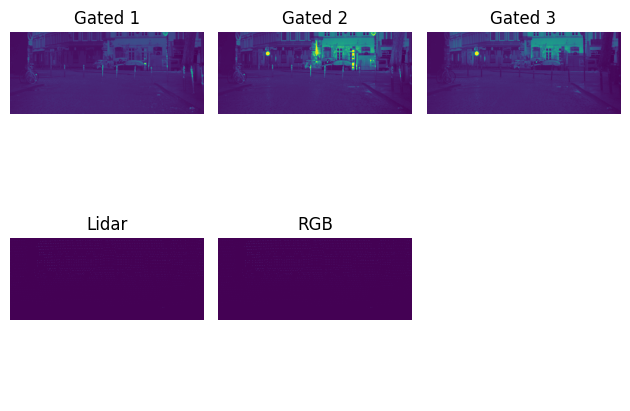

In [5]:
#测试数据读取

import matplotlib.pyplot as plt

base_dir = '../example'
gta_pass = ''
data_type = 'real'
img_id = 'example_day'
min_distance = 3.
max_distance = 150.

# 从数据文件中读取目标图像和激光雷达掩码
in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)
gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance,
                                     # raw_values_only=True
                                     )

# 测试保存concatenate后的数据
in_dir = '../data/real/gated'
depth_dir = '../data/real/depth'
np.save(in_dir +img_id +'.npy', in_img)
laod_in_img = np.load(in_dir +img_id +'.npy')


figShape = [720 - crop_size * 2, 1280 - crop_size * 2]
# 创建一个2x2的子图布局
fig, axs = plt.subplots(2, 3)
# 在子图上绘图
axs[0, 0].set_title('Gated 1')
axs[0, 0].imshow(laod_in_img[:, :, :, 0:1].reshape(figShape))
axs[0, 0].axis('off')

axs[0, 1].set_title('Gated 2')
axs[0, 1].imshow(in_img[:, :, :, 1:2].reshape(figShape))
axs[0, 1].axis('off')

axs[0, 2].set_title('Gated 3')
axs[0, 2].imshow(in_img[:, :, :, 2:3].reshape(figShape))
axs[0, 2].axis('off')

axs[1, 0].set_title('Lidar')
axs[1, 0].imshow(gt_patch.reshape(figShape))
axs[1, 0].axis('off')

axs[1, 1].set_title('RGB')
axs[1, 1].imshow(gt_patch.reshape(figShape))
axs[1, 1].axis('off')
axs[1, 2].axis('off')
# 调整子图之间的间距
plt.tight_layout()
plt.show()


In [20]:
import os
import tensorflow as tf

data_dir = '../example'
sample_ids = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'gated0_10bit'))]

def load_sample(sample_id):
    input1_path = os.path.join(data_dir, 'gated0_10bit', sample_id + '.png')
    input2_path = os.path.join(data_dir, 'gated1_10bit', sample_id + '.png')
    input3_path = os.path.join(data_dir, 'gated2_10bit', sample_id + '.png')
    depth_path = os.path.join(data_dir, 'depth_hdl64_gated_compressed', sample_id + '.npz')
    
    input1 = tf.image.decode_png(tf.io.read_file(input1_path), channels=1)
    input2 = tf.image.decode_png(tf.io.read_file(input2_path), channels=1)
    input3 = tf.image.decode_png(tf.io.read_file(input3_path), channels=1)
    depth = np.load(depth_path)['arr_0']
    depth = np.float32(np.clip(depth, min_distance, max_distance) / max_distance)
    depth = np.expand_dims(depth, axis=2) #改为[height, width, 1]
    
    inputs = tf.stack([input1, input2, input3], axis=-1)
    inputs = tf.squeeze(inputs, axis=-2) #将数据形状更改为[height, width, 3],以适应网络
    return inputs, depth

inputs1, depth1 = load_sample(sample_ids[0])

dataset = tf.data.Dataset.from_tensor_slices(sample_ids)
dataset = dataset.map(
    lambda x: tf.py_function(
        load_sample, [x], [tf.float32, tf.float32]), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)



KeyboardInterrupt: 

In [9]:
#测试unet
import unet
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=10096)])
    except RuntimeError as e:
        print(e)

# 测试
# input_img = tf.keras.Input(shape=(420, 980, 3))
input_img = tf.keras.Input(shape=(720, 1280, 3))
model = tf.keras.Model(inputs=input_img, outputs=unet.build_unet(input_img))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error')
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


KeyboardInterrupt: 

In [ ]:
model.fit(dataset,
          epochs=3,
          batch_size=32,
          validation_split=0.1)